In [534]:
import sqlite3
from math import exp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.5}".format
np.set_printoptions(formatter={"float_kind": float_formatter})


In [557]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


with sqlite3.connect("games2") as con:
    con.row_factory = dict_factory
    # new
    query3 = """
        SELECT
            g.result,
            p.eval,
            p.ply,
            g.elo_white - g.elo_black as elo_dif
        FROM
            games g INNER JOIN positions p
            ON g.rowid = p.game_id
        WHERE
            g.result != 0
            AND p.eval is not NULL
        """

    # query2 = """
    #     SELECT 
    #         g.result,
    #         MIN(m.eval) as eval_min,
    #         MAX(m.eval) as eval_max,
    #         AVG(m.eval) as eval_avg
    #     FROM 
    #         games g INNER JOIN moves m 
    #         ON g.url = m.url
    #     WHERE
    #         g.result != 3
    #         AND m.eval is not NULL
    #         AND m.eval < 9900
    #         AND m.eval > -9900
    #     GROUP BY g.url
    #     """

    res = con.execute(query3)
    df = pd.DataFrame(res)

con.close()


In [558]:
random_state = 42

features = [
    "eval",
    # "ply",
    # "elo_dif"
]
# features = ["eval_min", "eval_max"]
X = df[features]
y = df.result

classifier = LogisticRegressionCV(
    Cs=20,
    random_state=random_state,
    n_jobs=-1,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=np.linspace(0, 1, num=20),
    # class_weight="balanced",
    # fit_intercept=False
)

scaler = StandardScaler()
model = make_pipeline(scaler, classifier)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state, stratify=y
)

model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=20,
                                      l1_ratios=array([0.0, 0.052632, 0.10526, 0.15789, 0.21053, 0.26316, 0.31579,
       0.36842, 0.42105, 0.47368, 0.52632, 0.57895, 0.63158, 0.68421,
       0.73684, 0.78947, 0.84211, 0.89474, 0.94737, 1.0]),
                                      n_jobs=-1, penalty='elasticnet',
                                      random_state=42, solver='saga'))])

<AxesSubplot: xlabel='elo_dif', ylabel='result'>

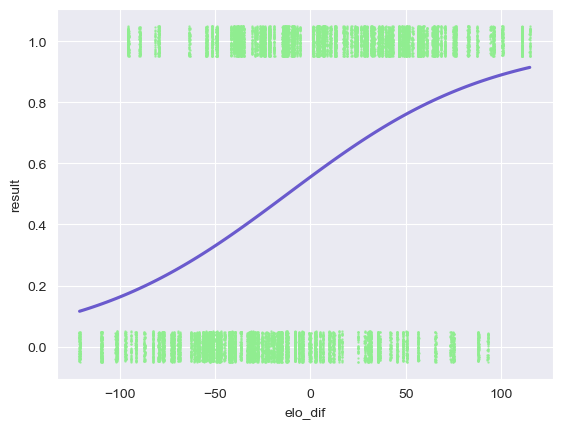

In [559]:
sns.regplot(
    data=(df + 1) / 2,
    x="elo_dif",
    y="result",
    y_jitter=0.05,
    x_jitter=0.2,
    logistic=True,
    n_boot=1,
    ci=1,
    scatter_kws={"s": 0.5, "color": "lightgreen"},
    color="slateblue",
)


In [560]:
print(f"Accuracy: \n {model.score(X_test, y_test)}")
scale = model.named_steps["standardscaler"].scale_

coefs = model.named_steps["logisticregressioncv"].coef_ / scale
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["logisticregressioncv"].intercept_ / scale
print(f"Intercept: \n {intercept}")

cs = model.named_steps["logisticregressioncv"].C_
print(f"Regularization strenght: \n {cs}")


Accuracy: 
 0.7238405965975298
Coefficients: 
 [[0.0027711]]
Intercept: 
 [0.00018341]
Regularization strenght: 
 [0.23357]


<AxesSubplot: xlabel='ply', ylabel='eval'>

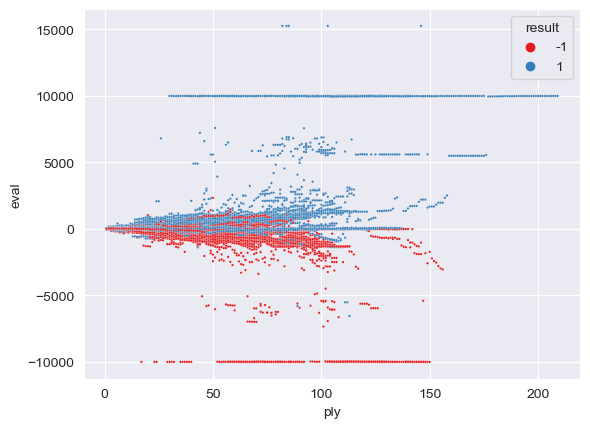

In [561]:
sns.scatterplot(
    df,
    x="ply",
    y="eval",
    hue="result",
    s=3,
    palette="Set1",
)


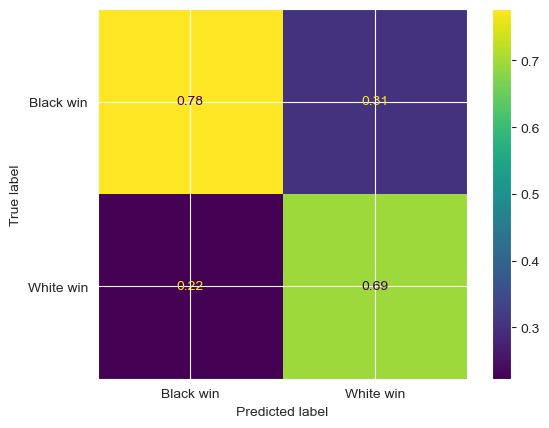

In [563]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    normalize="pred",
    display_labels=[
        "Black win",
        # "Draw",
        "White win",
    ],
)


In [581]:
test_pawn = -100
model.predict_proba([[test_pawn]])

c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.56204, 0.43796]])

In [582]:

testcase = 1 / (1 + exp(-coefs * test_pawn - intercept))
print(f"Tested coefs: {testcase}")

Tested coefs: 0.43120681399865723
